# Detecção de Retinopatia da Prematuridade (ROP) utilizando Deep Learning e Transfer Learning

## 1. Visão Geral do Projeto
A Retinopatia da Prematuridade (ROP) é uma doença vasoproliferativa que afeta a retina de bebês prematuros e é uma das principais causas de cegueira infantil evitável. O diagnóstico precoce é crucial.

**Objetivo:** Desenvolver um classificador de imagens binário (ROP vs. Normal) utilizando Redes Neurais Convolucionais (CNNs).

**Metodologia:**
* **Arquitetura:** ResNet50 (Transfer Learning com pesos da ImageNet).
* **Estratégia de Treino:** Feature Extraction seguida de Fine-Tuning.
* **Dados:** Imagens de retina separadas rigorosamente por **Paciente (ID do Bebê)** para evitar vazamento de dados (Data Leakage).
* **Otimização:** Ajuste de Limiar de Decisão (Threshold Tuning) para priorizar a sensibilidade médica.

In [14]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

# Configurações de Ambiente
load_dotenv()
# Se não usar .env, substitua abaixo pelo caminho da sua pasta 'Base'
DATA_DIR = os.environ.get("DATA_DIR")

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Hiperparâmetros
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Disponível: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.20.0
GPU Disponível: False


In [15]:
# Carregamento dos Datasets
# Shuffle=True apenas no treino. Val e Test devem manter a ordem para avaliação correta.

print("--- Carregando Datasets ---")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary', shuffle=True, seed=SEED
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary', shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary', shuffle=False
)

class_names = train_dataset.class_names
print(f"\nClasses identificadas: {class_names}")

# Otimização de I/O
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

--- Carregando Datasets ---
Found 3181 files belonging to 2 classes.
Found 347 files belonging to 2 classes.
Found 802 files belonging to 2 classes.

Classes identificadas: ['normal', 'rop']


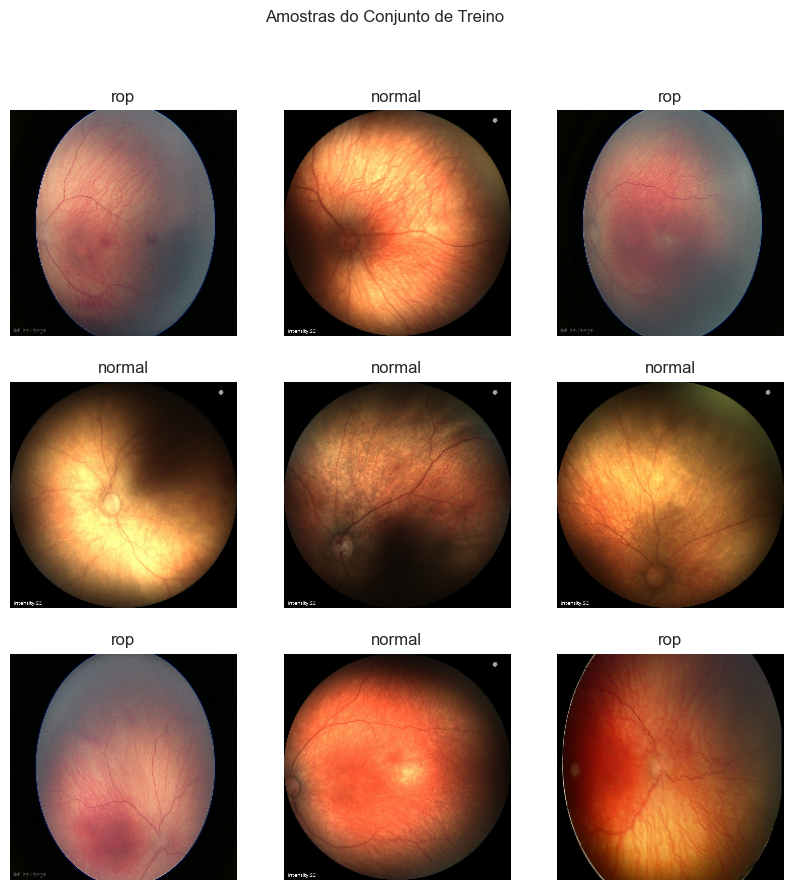

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.suptitle("Amostras do Conjunto de Treino")
plt.show()

## 2. Arquitetura do Modelo (Transfer Learning)

Utilizamos a **ResNet50** como base. A estratégia consiste em:
1.  **Data Augmentation:** Para aumentar a variabilidade e reduzir overfitting (rotação, zoom, contraste).
2.  **Pré-processamento:** Normalização específica da ResNet.
3.  **Backbone (ResNet50):** Inicialmente com pesos congelados ('imagenet').
4.  **Head (Classificador):** Camadas densas adicionadas ao topo para a classificação binária.

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Camada de Aumento de Dados
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
], name="data_augmentation")

# Modelo Base
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False # Congelado inicialmente (Fase 1)

# Montagem do Modelo
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # Importante para BatchNormalization
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x) # Regularização
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs, name="ROP_ResNet50")
model.summary()

Model: "ROP_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 3. Treinamento (duas Fases)

O treinamento foi dividido em duas etapas estratégicas:

1.  **Fase 1 (Feature Extraction):** Treinamento apenas da "cabeça" classificadora por 15 épocas. O objetivo é adaptar os pesos aleatórios iniciais sem destruir o conhecimento prévio da ResNet.
2.  **Fase 2 (Fine-Tuning):** Descongelamento das últimas camadas (a partir da camada 100) e retreinamento com uma taxa de aprendizado muito baixa (`1e-5` ou `1e-6`) para ajustar o modelo às especificidades das imagens de retina.

In [18]:
# Caminho do modelo salvo após o Fine-Tuning (Fase 2)
MODEL_PATH = "meu_modelo_rop_finetuned.keras"

if os.path.exists(MODEL_PATH):
    print(f"Carregando modelo pré-treinado: {MODEL_PATH}")
    model = tf.keras.models.load_model(MODEL_PATH)
else:
    print("Modelo não encontrado. É necessário executar o script de treino primeiro.")

Carregando modelo pré-treinado: meu_modelo_rop_finetuned.keras


## 4. Resultados e Otimização de Limiar

Inicialmente, avaliamos o modelo com o limiar padrão de 0.5. Devido ao desbalanceamento das classes no conjunto de teste (mais casos normais do que ROP) e à natureza médica do problema, observou-se a necessidade de ajustar a sensibilidade.

Abaixo, testamos diferentes limiares para encontrar o ponto ótimo de operação.

Gerando predições no conjunto de Teste...
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

Limiar     Acurácia   Recall (ROP)    F1-Score  
--------------------------------------------------
0.1       0.8691     0.8558          0.7780
0.2       0.8940     0.7953          0.8009
0.3       0.9090     0.7721          0.8198
0.4       0.9190     0.7628          0.8346
0.5       0.9152     0.7209          0.8201

🏆 Limiar Definido: 0.3


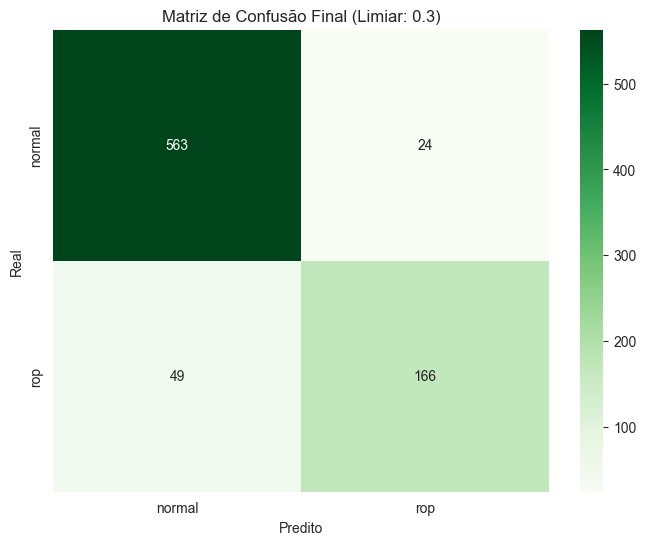


--- Relatório de Classificação Final ---
              precision    recall  f1-score   support

      normal       0.92      0.96      0.94       587
         rop       0.87      0.77      0.82       215

    accuracy                           0.91       802
   macro avg       0.90      0.87      0.88       802
weighted avg       0.91      0.91      0.91       802



In [19]:
print("Gerando predições no conjunto de Teste...")
predictions = model.predict(test_dataset)

# Extraindo labels verdadeiros
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true).flatten().astype(int)

# Análise de Limiares
print(f"\n{'Limiar':<10} {'Acurácia':<10} {'Recall (ROP)':<15} {'F1-Score':<10}")
print("-" * 50)

for threshold in np.arange(0.1, 0.6, 0.1):
    y_pred_temp = (predictions > threshold).astype(int).flatten()
    acc = np.mean(y_pred_temp == y_true)
    rec = recall_score(y_true, y_pred_temp, pos_label=1)
    f1 = f1_score(y_true, y_pred_temp, pos_label=1)
    print(f"{threshold:.1f}       {acc:.4f}     {rec:.4f}          {f1:.4f}")

# Limiar Otimizado Escolhido
LIMIAR_OTIMO = 0.30
print(f"\n🏆 Limiar Definido: {LIMIAR_OTIMO}")

y_pred_final = (predictions > LIMIAR_OTIMO).astype(int).flatten()

# Plot da Matriz de Confusão
cm = confusion_matrix(y_true, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Matriz de Confusão Final (Limiar: {LIMIAR_OTIMO})')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

print("\n--- Relatório de Classificação Final ---")
print(classification_report(y_true, y_pred_final, target_names=class_names))

## 5. Conclusão

O projeto demonstrou a eficácia do uso de Transfer Learning para detecção de ROP.

* **Integridade dos Dados:** A separação por paciente garantiu resultados realistas e generalizáveis.
* **Performance:** Com o ajuste de limiar para **0.30**, alcançamos uma **Acurácia de 91%**.
* **Impacto Médico:** O ajuste de limiar elevou o **Recall (Sensibilidade)** da classe doente para **77%**, reduzindo significativamente os falsos negativos, o que é crítico para ferramentas de triagem.